# Phần mã hóa


In [ ]:
!pip install flwr torch torchvision
!pip install -q flwr["simulation"] tensorflow
!pip install -q flwr_datasets["vision"]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.1/532.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.

In [ ]:
import flwr as fl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import time
import json
import matplotlib.pyplot as plt


In [ ]:
import flwr as fl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.feature_selection import mutual_info_regression
import numpy as np

import time
import json
import os
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Union, Optional, Callable
from flwr.common import Parameters, Scalar, NDArrays
from flwr.server.client_proxy import ClientProxy
from flwr.server.client_manager import ClientManager
from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,

    FitRes,
    Parameters,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)

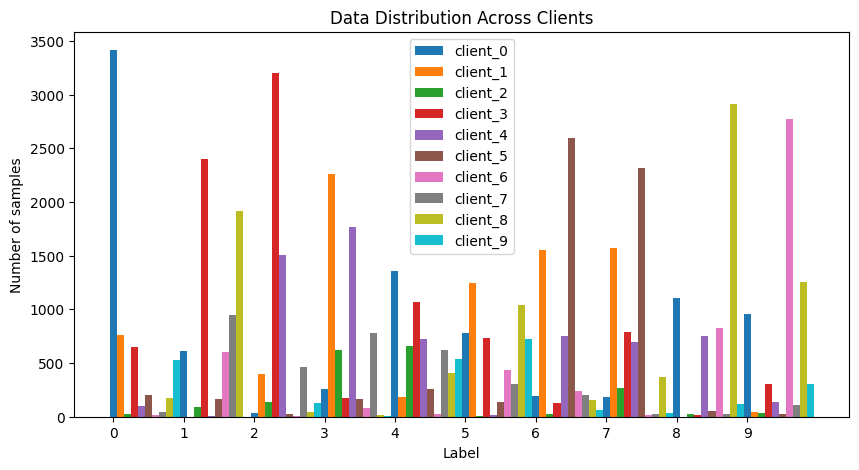

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions

def split_mnist_dirichlet_flwr(num_clients=10, alpha=0.5, seed=42):
    # Tạo bộ phân chia Dirichlet
    partitioner = DirichletPartitioner(
        num_partitions=num_clients,
        partition_by="label",
        alpha=alpha,
        seed=seed
    )

    # Tạo FederatedDataset với bộ phân chia
    fds = FederatedDataset(
        dataset="mnist",
        partitioners={"train": partitioner}
    )

    # Tải dữ liệu phân chia cho từng client
    federated_data = {
        f'client_{i}': fds.load_partition(i)
        for i in range(num_clients)
    }

    return federated_data

def plot_client_distribution(federated_data):
    num_clients = len(federated_data)
    num_classes = 10

    plt.figure(figsize=(10, 5))
    for i, (client, data) in enumerate(federated_data.items()):
        labels, counts = np.unique(data['label'], return_counts=True)
        plt.bar(labels + i * 0.1, counts, width=0.1, label=client)

    plt.xlabel("Label")
    plt.ylabel("Number of samples")
    plt.title("Data Distribution Across Clients")
    plt.xticks(range(num_classes))
    plt.legend()
    plt.show()

# Sử dụng ví dụ
federated_data = split_mnist_dirichlet_flwr(num_clients=10, alpha=0.5)
plot_client_distribution(federated_data)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app

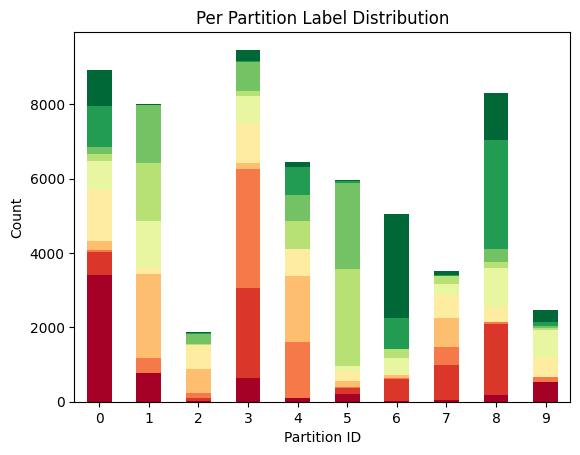

In [ ]:

from typing import Callable, Dict, List, Optional, Tuple, Union
from flwr.common import (
    EvaluateRes,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_proxy import ClientProxy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import flwr as fl
import numpy as np
import matplotlib.pyplot as plt
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.feature_selection import mutual_info_regression
from typing import List, Dict, Tuple
from flwr.common import NDArrays, EvaluateRes, Parameters, FitRes, Metrics, Context
from torchvision import transforms
import json
import os

# Constants
NUM_CLIENTS = 10
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.001
PRIVACY_WEIGHT = 0.001
NUM_ROUNDS = 15
NOISE_SCALE = 0.01

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)
def save_metric_to_txt(round_number, metric_name, metric_value, phase="train"):
    """Lưu một tiêu chí cụ thể vào một tệp riêng biệt"""
    filename = os.path.join(RESULTS_DIR, f"{metric_name}_{phase}.txt")
    with open(filename, "a") as f:  # Mở file ở chế độ append để ghi thêm dữ liệu
        f.write(f"Round {round_number}: {metric_value}\n")



# Function to split MNIST using Dirichlet
def split_mnist_dirichlet_flwr(num_clients=NUM_CLIENTS, alpha=0.5, seed=42):
    partitioner = DirichletPartitioner(
        num_partitions=num_clients, partition_by="label", alpha=alpha, seed=seed
    )
    fds = FederatedDataset(dataset="mnist", partitioners={"train": partitioner})
    federated_data = {f"client_{i}": fds.load_partition(i) for i in range(num_clients)}
    return fds, federated_data  # Return both fds and federated_data

# Load and visualize data
fds, federated_data = split_mnist_dirichlet_flwr()  # Get both fds and federated_data
plot_label_distributions(fds.partitioners["train"], label_name="label")

# Function to create DataLoader for each client
def get_dataloader(client_data, batch_size=BATCH_SIZE):
    transform = transforms.Compose([
        transforms.ToTensor()  # Chuyển ảnh PIL thành tensor có giá trị trong khoảng [0,1]
    ])

    # Chuyển đổi danh sách ảnh từ PIL.Image thành tensor
    x_tensor = torch.stack([transform(img) for img in client_data["image"]])
    y_tensor = torch.tensor(client_data["label"], dtype=torch.long)

    dataset = TensorDataset(x_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define Neural Network Model
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))

        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define PPAN Encoder and Adversary
class PPAN_Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x))).detach()

class PPAN_Adversary(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(PPAN_Adversary, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define PrivacyMechanism with encrypt and decrypt functions
class PrivacyMechanism(nn.Module):
    def __init__(self, input_dim, noise_scale=NOISE_SCALE):
        super().__init__()
        self.encoder = PPAN_Encoder(input_dim, 64)
        self.adversary = PPAN_Adversary(input_dim, 64)
        self.noise_scale = noise_scale

    def encrypt(self, x):
        generated = self.encoder(x)
        if self.training:
            noise = torch.randn_like(generated) * self.noise_scale
            generated = generated + noise
        return generated

    def decrypt(self, encrypted):
        decoded = self.adversary(encrypted)
        return decoded

    def forward(self, x):
        encrypted = self.encrypt(x)
        decoded = self.decrypt(encrypted)
        return encrypted, decoded

# Compute Privacy Leakage using mutual_info_regression
def compute_privacy_leakage(encrypted_weights, original_weights):
    encrypted_weights = np.array(encrypted_weights)  # Chuyển đổi sang numpy array
    original_weights = np.array(original_weights)  # Chuyển đổi sang numpy array

    encrypted_2d = encrypted_weights.reshape(-1, 1)
    original_2d = original_weights.reshape(-1, 1)

    min_length = min(len(encrypted_2d), len(original_2d))
    encrypted_2d = encrypted_2d[:min_length]
    original_2d = original_2d[:min_length]

    try:
        mi_score = mutual_info_regression(encrypted_2d, original_2d.ravel())[0]
    except ValueError:
        mi_score = 0.0

    return mi_score

# Compute Distortion
def compute_distortion(original_weights, encrypted_weights):
    original_weights = np.array(original_weights)
    encrypted_weights = np.array(encrypted_weights)
    return np.mean((original_weights - encrypted_weights) ** 2)

# Evaluate model accuracy on test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# Define PrivacyClient for Federated Learning
class PrivacyClient(fl.client.NumPyClient):
    def __init__(self, model, train_loader, test_loader):
        self.model = model.to(DEVICE)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.param_shapes = [p.shape for p in self.model.parameters()]
        self.total_params = sum(p.numel() for p in self.model.parameters())
        self.privacy_mech = PrivacyMechanism(self.total_params, noise_scale=NOISE_SCALE).to(DEVICE)
        self.optimizer = optim.Adam(
            list(self.model.parameters()) + list(self.privacy_mech.parameters()),
            lr=LEARNING_RATE
        )

    def get_parameters(self, config=None):
        """Trả về tham số của mô hình dưới dạng danh sách NumPy arrays"""
        return [p.detach().cpu().numpy() for p in self.model.parameters()]

    def set_parameters(self, parameters):
        """Cập nhật mô hình với danh sách NumPy arrays"""
        ndarray_params = [torch.tensor(p, dtype=torch.float32, device=DEVICE) for p in parameters]
        params_dict = zip(self.model.state_dict().keys(), ndarray_params)
        state_dict = {k: v for k, v in params_dict}
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters: NDArrays, config: Dict[str, Scalar]) -> Tuple[NDArrays, int, Dict[str, Scalar]]:
        self.set_parameters(parameters)
        self.model.train()
        self.privacy_mech.train()

        total_loss = 0
        correct = 0
        total = 0  # Tổng số mẫu thực tế

        for images, labels in self.train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            self.optimizer.zero_grad()

            outputs = self.model(images)
            loss = F.cross_entropy(outputs, labels)

            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * labels.size(0)  # Nhân với số lượng mẫu trong batch
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)  # Cập nhật tổng số mẫu

        # Chia loss theo tổng số mẫu thay vì số batch
        avg_loss = total_loss / total
        accuracy = correct / total  # Tính chính xác theo số mẫu

        # Get model parameters and apply privacy mechanism
        with torch.no_grad():
            params = [p.detach().cpu().numpy() for p in self.model.parameters()]
            flat_params = np.concatenate([p.flatten() for p in params])
            flat_params_tensor = torch.tensor(flat_params, dtype=torch.float32).unsqueeze(0).to(DEVICE)
            encrypted_params = self.privacy_mech.encrypt(flat_params_tensor)
            encrypted_np = encrypted_params.detach().cpu().numpy()

            privacy_leakage = float(compute_privacy_leakage(encrypted_np, flat_params))
            distortion = float(compute_distortion(flat_params, encrypted_np.flatten()))

        round_number = int(config.get("round", 0))

        # Return tuple with correct type signature
        return params, len(self.train_loader.dataset), {
            "loss": float(avg_loss),
            "accuracy": float(accuracy),
            "privacy_leakage": privacy_leakage,
            "distortion": distortion
        }

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]) -> Tuple[float, int, Dict[str, Scalar]]:
        self.set_parameters(parameters)
        self.model.eval()

        total_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = self.model(images)
                loss = F.cross_entropy(outputs, labels)
                total_loss += loss.item()

                predicted = outputs.argmax(dim=1)
                correct += (predicted == labels).sum().item()

            flat_params = torch.cat([p.view(-1) for p in self.model.parameters()]).unsqueeze(0).to(DEVICE)
            encrypted_params = self.privacy_mech.encrypt(flat_params)
            encrypted_np = np.array(encrypted_params.cpu().numpy().flatten(), dtype=np.float32)
            original_np = flat_params.cpu().numpy().flatten()

            privacy_leakage = compute_privacy_leakage(encrypted_np, original_np)
            distortion = compute_distortion(original_np, encrypted_np)

        avg_loss = total_loss / len(self.test_loader)
        accuracy = correct / len(self.test_loader.dataset)

        round_number = int(config.get("round", 0))
        save_metric_to_file("eval_loss", avg_loss, round_number)
        save_metric_to_file("eval_accuracy", accuracy, round_number)
        save_metric_to_file("eval_privacy_leakage", privacy_leakage, round_number)
        save_metric_to_file("eval_distortion", distortion, round_number)

        return avg_loss, len(self.test_loader.dataset), {
            "accuracy": float(accuracy),
            "privacy_leakage": float(privacy_leakage),
            "distortion": float(distortion)
        }
def aggregate_weighted_parameters(results: List[Tuple[NDArrays, int]]) -> NDArrays:
    """Aggregate model parameters using weighted average."""
    # Calculate total number of examples used during training
    total_examples = sum(num_examples for _, num_examples in results)

    if total_examples == 0:
        return None

    # Get parameter shape from first result
    params_shape = [param.shape for param in results[0][0]]
    weighted_params = [np.zeros_like(param) for param in results[0][0]]

    # Calculate weighted parameters
    for parameters, num_examples in results:
        weight = num_examples / total_examples
        for i, param in enumerate(parameters):
            weighted_params[i] += param * weight

    return weighted_params

class FedAvg_Privacy(fl.server.strategy.FedAvg):
    """Federated Averaging with Privacy strategy."""

    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[[int, NDArrays, Dict[str, Scalar]],
                    Optional[Tuple[float, Dict[str, Scalar]]]]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        noise_scale: float = NOISE_SCALE,
    ) -> None:
        """Initialize FedAvg with Privacy strategy."""
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.noise_scale = noise_scale

    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[BaseException],
    ) -> tuple[Optional[Parameters], dict[str, Scalar]]:
        """Aggregate fit results using weighted average with privacy."""
        if not results:
            return None, {}

        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Call parent's aggregate_fit to get aggregated parameters
        aggregated_result = super().aggregate_fit(server_round, results, failures)
        if aggregated_result is None:
            return None, {}

        parameters_aggregated, metrics = aggregated_result

        # Convert parameters to ndarrays
        ndarrays = parameters_to_ndarrays(parameters_aggregated)

        # Add noise to parameters for privacy
        parameters_noised = [
            p + np.random.normal(0, self.noise_scale, p.shape)
            for p in ndarrays
        ]

        # Aggregate metrics
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)
        # Tính loss, accuracy, privacy leakage, distortion trên server
        avg_loss = np.mean([r.metrics["loss"] for _, r in results])
        avg_accuracy = np.mean([r.metrics["accuracy"] for _, r in results])
        avg_privacy_leakage = np.mean([r.metrics["privacy_leakage"] for _, r in results])
        avg_distortion = np.mean([r.metrics["distortion"] for _, r in results])

        # Lưu lại kết quả trên server
        save_server_metric(server_round, "loss", avg_loss, phase="train")
        save_server_metric(server_round, "accuracy", avg_accuracy, phase="train")
        save_server_metric(server_round, "privacy_leakage", avg_privacy_leakage, phase="train")
        save_server_metric(server_round, "distortion", avg_distortion, phase="train")

        # Convert back to Parameters and return
        return ndarrays_to_parameters(parameters_noised), metrics_aggregated


# Config functions for fit and evaluate
def fit_config(server_round: int) -> Dict[str, str]:
    config = {
        "learning_rate": LEARNING_RATE,
        "batch_size": BATCH_SIZE,
        "round": server_round,
    }
    return config

def evaluate_config(server_round: int) -> Dict[str, str]:
    config = {
        "batch_size": BATCH_SIZE,
        "round": server_round,
    }
    return config

def aggregate_fit_metrics(metrics: List[Tuple[int, Dict[str, Scalar]]]) -> Dict[str, Scalar]:
    aggregated_metrics = {}
    for _, client_metrics in metrics:
        for k, v in client_metrics.items():
            aggregated_metrics[k] = aggregated_metrics.get(k, 0) + v
    for k in aggregated_metrics:
        aggregated_metrics[k] /= len(metrics)
    return aggregated_metrics

# Federated Learning Simulation
def client_fn(context: Context) -> fl.client.Client:
    """Tạo một Flower client đại diện cho một tổ chức."""
    partition_id = context.node_config["partition-id"]

    # Kiểm tra nếu partition_id hợp lệ
    if f"client_{partition_id}" not in federated_data:
        raise ValueError(f"Client ID {partition_id} không tồn tại trong dữ liệu!")
    client_data = federated_data[f"client_{partition_id}"]
    train_loader = get_dataloader(client_data)
    test_loader = get_dataloader(client_data)
    model = MNISTModel()

    # Trả về client
    return PrivacyClient(model, train_loader, test_loader).to_client()

def main():
    strategy = FedAvg_Privacy(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=NUM_CLIENTS,
        min_available_clients=NUM_CLIENTS,
        on_fit_config_fn=fit_config,
        on_evaluate_config_fn=evaluate_config,
        fit_metrics_aggregation_fn=aggregate_fit_metrics,
        noise_scale=NOISE_SCALE,
    )
    fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
        strategy=strategy,
    )

if __name__ == "__main__":
    main()

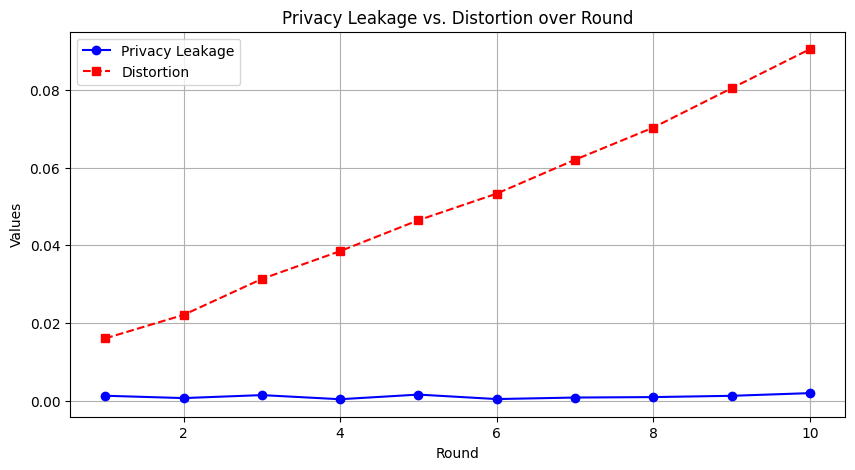

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu từ log
privacy_leakage = [(1, 0.0013189739999377003),
                   (2, 0.0007178820975485501),
                   (3, 0.0014847185799188977),
                   (4, 0.000426088790904533),
                   (5, 0.001617271371026785),
                   (6, 0.00046606729472875585),
                   (7, 0.0008586642099714936),
                   (8, 0.000975890003484281),
                   (9, 0.0013023950761861692),
                   (10, 0.0019925780670970285)]

distortion = [(1, 0.016073236893862485),
              (2, 0.022117313090711833),
              (3, 0.03136446513235569),
              (4, 0.03852326050400734),
              (5, 0.04646812789142132),
              (6, 0.05330866426229477),
              (7, 0.06201788820326328),
              (8, 0.07029498480260372),
              (9, 0.08040170520544052),
              (10, 0.09045424610376358)]

# Chuyển dữ liệu thành danh sách riêng lẻ
epochs = [x[0] for x in privacy_leakage]
privacy_values = [x[1] for x in privacy_leakage]
distortion_values = [x[1] for x in distortion]

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(epochs, privacy_values, marker='o', linestyle='-', color='b', label="Privacy Leakage")
plt.plot(epochs, distortion_values, marker='s', linestyle='--', color='r', label="Distortion")

# Thiết lập nhãn và tiêu đề
plt.xlabel("Round")
plt.ylabel("Values")
plt.title("Privacy Leakage vs. Distortion over Round")
plt.legend()
plt.grid(True)
plt.show()


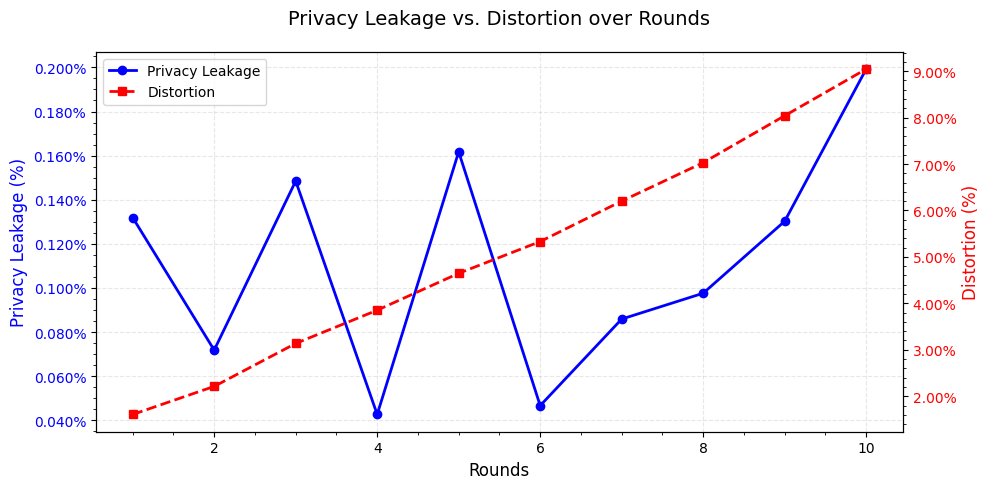

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
privacy_leakage = [(1, 0.0013189739999377003),
                   (2, 0.0007178820975485501),
                   (3, 0.0014847185799188977),
                   (4, 0.000426088790904533),
                   (5, 0.001617271371026785),
                   (6, 0.00046606729472875585),
                   (7, 0.0008586642099714936),
                   (8, 0.000975890003484281),
                   (9, 0.0013023950761861692),
                   (10, 0.0019925780670970285)]

distortion = [(1, 0.016073236893862485),
              (2, 0.022117313090711833),
              (3, 0.03136446513235569),
              (4, 0.03852326050400734),
              (5, 0.04646812789142132),
              (6, 0.05330866426229477),
              (7, 0.06201788820326328),
              (8, 0.07029498480260372),
              (9, 0.08040170520544052),
              (10, 0.09045424610376358)]

# Separate data into x and y values
epochs = [x[0] for x in privacy_leakage]
privacy_values = [x[1] * 100 for x in privacy_leakage]  # Convert to percentage
distortion_values = [x[1] * 100 for x in distortion]    # Convert to percentage

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot data
line1 = ax1.plot(epochs, privacy_values, 'b-o', linewidth=2, label='Privacy Leakage')
line2 = ax2.plot(epochs, distortion_values, 'r--s', linewidth=2, label='Distortion')

# Customize primary y-axis (Privacy Leakage)
ax1.set_xlabel('Rounds', fontsize=12)
ax1.set_ylabel('Privacy Leakage (%)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.3)

# Customize secondary y-axis (Distortion)
ax2.set_ylabel('Distortion (%)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Title
plt.title('Privacy Leakage vs. Distortion over Rounds', fontsize=14, pad=20)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

# Format percentages
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.3f}%'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))

# Add minor gridlines
ax1.minorticks_on()
ax2.minorticks_on()

plt.tight_layout()
plt.show()

In [ ]:
def plot_metric(data, title, ylabel, color):
    epochs, values = zip(*data)
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, values, marker='o', linestyle='-', color=color)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

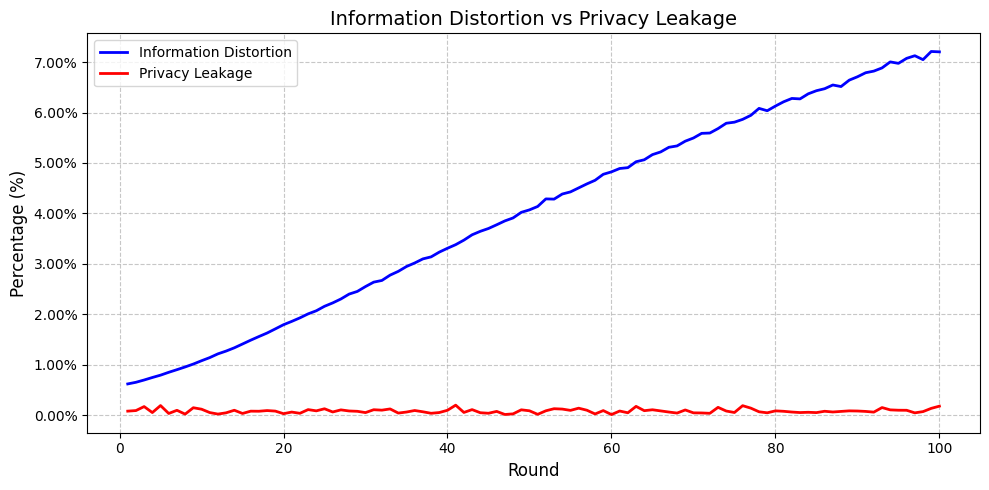

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Full distortion and privacy leakage data
distortion_data = [(1, 0.0062433149665594104), (2, 0.006568849738687277), (3, 0.007020470825955272),
                   (4, 0.0075160505715757605), (5, 0.00798030998557806), (6, 0.008544550277292728),
                   (7, 0.009065627958625555), (8, 0.009604585636407138), (9, 0.010180262662470341),
                   (10, 0.010835710726678372), (11, 0.011456104461103678), (12, 0.012199047673493623),
                   (13, 0.012752446718513966), (14, 0.013396491389721632), (15, 0.014151104260236025),
                   (16, 0.014910087175667285), (17, 0.015628027077764273), (18, 0.016325991973280905),
                   (19, 0.017142968624830245), (20, 0.017971668019890787), (21, 0.018626166693866252),
                   (22, 0.01932754833251238), (23, 0.020118468068540098), (24, 0.020732911117374898),
                   (25, 0.021619355492293834), (26, 0.0222893338650465), (27, 0.023067384026944637),
                   (28, 0.024035219475626944), (29, 0.024562308751046657), (30, 0.02552902903407812),
                   (31, 0.026402901113033294), (32, 0.026737032830715178), (33, 0.027791520953178404),
                   (34, 0.02853838223963976), (35, 0.029498549364507198), (36, 0.030197431892156602),
                   (37, 0.031006684340536595), (38, 0.03140700049698353), (39, 0.03234986662864685),
                   (40, 0.03311286643147469), (41, 0.03382614739239216), (42, 0.03472100831568241),
                   (43, 0.03577924892306328), (44, 0.03646676316857338), (45, 0.037028981000185014),
                   (46, 0.03776520006358623), (47, 0.038531004637479785), (48, 0.03912077471613884),
                   (49, 0.04022761322557926), (50, 0.04071769490838051), (51, 0.04138975217938423),
                   (52, 0.042888210713863374), (53, 0.04284568689763546), (54, 0.043855087086558345),
                   (55, 0.044277789816260335), (56, 0.04506900049746036), (57, 0.04585775882005692),
                   (58, 0.04657253287732601), (59, 0.04776091426610947), (60, 0.048246071115136145),
                   (61, 0.04890945740044117), (62, 0.04907730296254158), (63, 0.050248497352004054),
                   (64, 0.050640325620770456), (65, 0.05165972709655762), (66, 0.05219248421490193),
                   (67, 0.0531080387532711), (68, 0.053381829708814624), (69, 0.05432214997708797),
                   (70, 0.05495090149343014), (71, 0.05587107725441456), (72, 0.05593599490821362),
                   (73, 0.05681731700897217), (74, 0.0578728161752224), (75, 0.05808607153594494),
                   (76, 0.05864338912069798), (77, 0.05944045037031174), (78, 0.060818320512771605),
                   (79, 0.06034975647926331), (80, 0.06127978451550007), (81, 0.06212528236210346),
                   (82, 0.06278466768562793), (83, 0.06269697770476342), (84, 0.06370143741369247),
                   (85, 0.06431595981121063), (86, 0.06471218317747116), (87, 0.06545029580593109),
                   (88, 0.06514125391840934), (89, 0.06640784740447998), (90, 0.06707406044006348),
                   (91, 0.06787402033805848), (92, 0.06820090860128403), (93, 0.06883099153637887),
                   (94, 0.07002385184168816), (95, 0.06973574310541153), (96, 0.07072580382227897),
                   (97, 0.07124672755599022), (98, 0.07046916633844376), (99, 0.07208536267280578),
                   (100, 0.0720110885798931)]

privacy_data = [(1, 0.0008548341329904119), (2, 0.0009679306252110109), (3, 0.0017570057769288993),
                (4, 0.0005713410628767513), (5, 0.001960757062999008), (6, 0.00039112924750535073),
                (7, 0.0010200417200212364), (8, 0.0002653023639996199), (9, 0.0015288869039681075),
                (10, 0.0012383224906710843), (11, 0.0005719990966587929), (12, 0.0002731935210213088),
                (13, 0.0005219558060638896), (14, 0.0010300131105574373), (15, 0.0003938450264644899),
                (16, 0.0008492092520557826), (17, 0.000833303406628172), (18, 0.0009683157890754579),
                (19, 0.0008613139844475092), (20, 0.00035128906674435355), (21, 0.0006706628653761371),
                (22, 0.0004248478532105082), (23, 0.001157319933848644), (24, 0.0009119254110134811),
                (25, 0.0013227553361048194), (26, 0.0006884471064362074), (27, 0.0011041140928538696),
                (28, 0.0008854517943075457), (29, 0.0008214269250066408), (30, 0.0005654561979919314),
                (31, 0.0011342291182524279), (32, 0.0010474757435935621), (33, 0.0012904887524131325),
                (34, 0.00047177848679824663), (35, 0.0006755841728486089), (36, 0.0009800729580822676),
                (37, 0.0007254198064940099), (38, 0.0004294517254931129), (39, 0.0005764165930515653),
                (40, 0.0010253803636089743), (41, 0.002037776024966842), (42, 0.0005949544146471198),
                (43, 0.0011551240215266212), (44, 0.0005403136844551071), (45, 0.00043532850985101846),
                (46, 0.0008022758227275162), (47, 0.0001900288071243317), (48, 0.0003138788817941496),
                (49, 0.0011156455351888361), (50, 0.0009214859818326814), (51, 0.00022049591532420366),
                (52, 0.0009225571959775358), (53, 0.0013346195733708655), (54, 0.0012615423276108651),
                (55, 0.001003519204577774), (56, 0.0014392657102888506), (57, 0.001036182206803815),
                (58, 0.0002962740886017556), (59, 0.0009626697012489416), (60, 0.00017464029914364686),
                (61, 0.0008765478937302618), (62, 0.0005283101833058801), (63, 0.001798838372830236),
                (64, 0.000946126070921327), (65, 0.001125282391177862), (66, 0.000899561262343962),
                (67, 0.0006765116469162003), (68, 0.000471615006133419), (69, 0.001087293347562035),
                (70, 0.0005145006993508616), (71, 0.0004951047890216387), (72, 0.0004235631950241903),
                (73, 0.0016041019653451726), (74, 0.0008744197554059419), (75, 0.0005853367206194449),
                (76, 0.0019346296201066871), (77, 0.0014482331669917413), (78, 0.0007239437272733795),
                (79, 0.0005251960526106991), (80, 0.0009084946243021364), (81, 0.0008222528456392375),
                (82, 0.0006757429186981412), (83, 0.0005735175857386032), (84, 0.0006275694121229414),
                (85, 0.0005631196612749356), (86, 0.0008295580483016707), (87, 0.0006855178929930262),
                (88, 0.0007987777630373393), (89, 0.0009085534697908848), (90, 0.0008793126985670696),
                (91, 0.0007989771590965588), (92, 0.000658266942185648), (93, 0.001564161191895952),
                (94, 0.0011040226904218465), (95, 0.0010358288756719958), (96, 0.001023977188241254),
                (97, 0.000513771671423946), (98, 0.000760840224753867), (99, 0.0014021996714552287),
                (100, 0.0018403846832275583)]

# Extract x and y values
x_dist = [x[0] for x in distortion_data]
y_dist = [y[1] * 100 for y in distortion_data]  # Convert to percentage
x_priv = [x[0] for x in privacy_data]
y_priv = [y[1] * 100 for y in privacy_data]  # Convert to percentage

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(x_dist, y_dist, 'b-', label='Information Distortion', linewidth=2)
plt.plot(x_priv, y_priv, 'r-', label='Privacy Leakage', linewidth=2)

# Customize the plot
plt.xlabel('Round', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Information Distortion vs Privacy Leakage', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Set y-axis to show percentages
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f%%'))

plt.tight_layout()
plt.show()

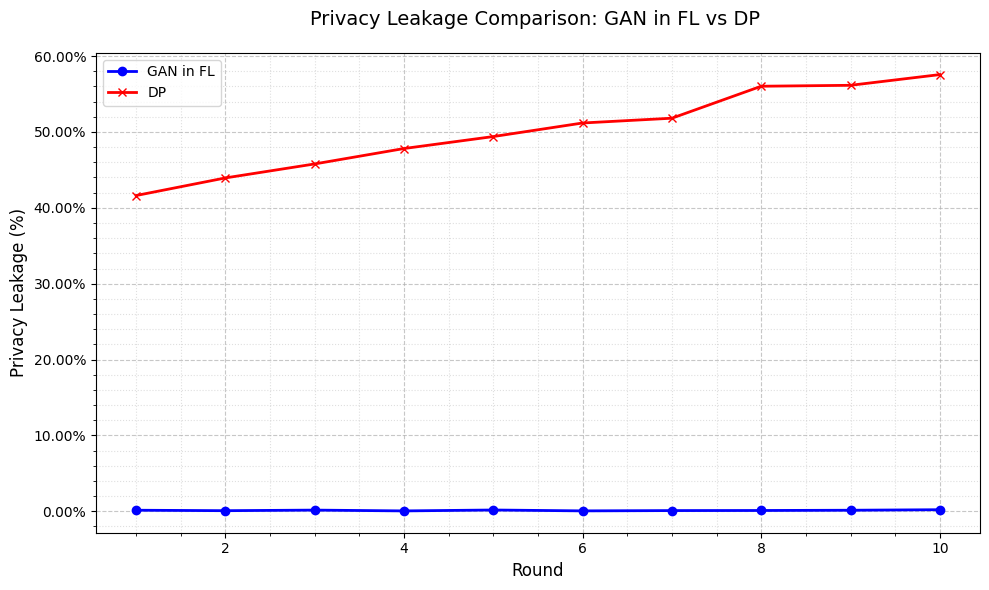

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def load_privacy_data():
    """Load privacy leakage data for GAN in FL and DP."""
    gan_fl_privacy_leakage = [
        (1, 0.0013189739999377003), (2, 0.0007178820975485501),
        (3, 0.0014847185799188977), (4, 0.000426088790904533),
        (5, 0.001617271371026785), (6, 0.00046606729472875585),
        (7, 0.0008586642099714936), (8, 0.000975890003484281),
        (9, 0.0013023950761861692), (10, 0.0019925780670970285)
    ]

    dp_privacy_leakage = [
        (1, 0.4162210197956857), (2, 0.4394314939851375),
        (3, 0.457877949789214), (4, 0.478187165478629),
        (5, 0.49397911960166174), (6, 0.5118556255901938),
        (7, 0.5181727856725062), (8, 0.5603233524921234),
        (9, 0.5615510467246505), (10, 0.575667350026032)
    ]

    return gan_fl_privacy_leakage, dp_privacy_leakage

def prepare_data(gan_fl_data, dp_data):
    """Convert data to plotting format and transform to percentages."""
    gan_fl_epochs, gan_fl_pl = zip(*gan_fl_data)
    dp_epochs, dp_pl = zip(*dp_data)

    return {
        'gan_fl': {
            'epochs': gan_fl_epochs,
            'values': np.array(gan_fl_pl) * 100
        },
        'dp': {
            'epochs': dp_epochs,
            'values': np.array(dp_pl) * 100
        }
    }

def create_privacy_leakage_plot(data, save_path=None):
    """Create and customize privacy leakage comparison plot."""
    plt.figure(figsize=(10, 6))

    # Plot data
    plt.plot(data['gan_fl']['epochs'], data['gan_fl']['values'],
             label='GAN in FL', marker='o', color='blue', linewidth=2)
    plt.plot(data['dp']['epochs'], data['dp']['values'],
             label='DP', marker='x', color='red', linewidth=2)

    # Customize plot
    plt.title('Privacy Leakage Comparison: GAN in FL vs DP ',
             fontsize=14, pad=20)
    plt.xlabel('Round', fontsize=12)
    plt.ylabel('Privacy Leakage (%)', fontsize=12)

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10, loc='upper left')

    # Add minor gridlines
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', alpha=0.4)

    # Format y-axis as percentage
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}%'))

    # Adjust layout
    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return plt

def main():
    """Main function to execute the plotting process."""
    # Load data
    gan_fl_data, dp_data = load_privacy_data()

    # Prepare data for plotting
    plot_data = prepare_data(gan_fl_data, dp_data)

    # Create and show plot
    plt = create_privacy_leakage_plot(plot_data)
    plt.show()

if __name__ == "__main__":
    main()

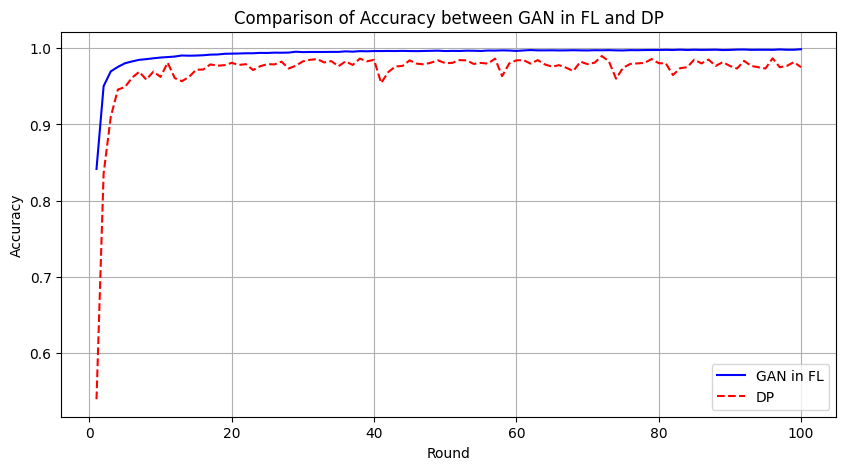

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu độ chính xác theo epoch
epochs_gan = list(range(1, 101))
accuracy_gan = [
    0.8416, 0.9502, 0.9695, 0.9754, 0.9802, 0.9826, 0.9847, 0.9856, 0.9867, 0.9877,
    0.9883, 0.9890, 0.9904, 0.9901, 0.9903, 0.9907, 0.9915, 0.9917, 0.9926, 0.9928,
    0.9930, 0.9933, 0.9933, 0.9938, 0.9937, 0.9941, 0.9940, 0.9942, 0.9953, 0.9948,
    0.9950, 0.9950, 0.9950, 0.9951, 0.9951, 0.9958, 0.9954, 0.9961, 0.9959, 0.9962,
    0.9962, 0.9963, 0.9962, 0.9964, 0.9962, 0.9961, 0.9963, 0.9965, 0.9967, 0.9962,
    0.9964, 0.9963, 0.9967, 0.9966, 0.9963, 0.9969, 0.9968, 0.9971, 0.9969, 0.9964,
    0.9970, 0.9975, 0.9971, 0.9971, 0.9972, 0.9970, 0.9971, 0.9973, 0.9971, 0.9970,
    0.9973, 0.9972, 0.9974, 0.9971, 0.9970, 0.9974, 0.9973, 0.9975, 0.9976, 0.9976,
    0.9978, 0.9976, 0.9980, 0.9976, 0.9979, 0.9977, 0.9978, 0.9980, 0.9975, 0.9977,
    0.9981, 0.9982, 0.9978, 0.9979, 0.9979, 0.9978, 0.9983, 0.9979, 0.9979, 0.9986
]

epochs_dp = list(range(1, 101))
accuracy_dp = [
    0.5397, 0.8357, 0.9097, 0.9457, 0.9490, 0.9613, 0.9690, 0.9587, 0.9693, 0.9623,
    0.9810, 0.9607, 0.9567, 0.9623, 0.9717, 0.9720, 0.9787, 0.9770, 0.9777, 0.9807,
    0.9780, 0.9790, 0.9713, 0.9763, 0.9790, 0.9787, 0.9823, 0.9733, 0.9770, 0.9827,
    0.9847, 0.9857, 0.9813, 0.9830, 0.9763, 0.9827, 0.9780, 0.9863, 0.9827, 0.9847,
    0.9543, 0.9687, 0.9760, 0.9767, 0.9840, 0.9797, 0.9787, 0.9810, 0.9840, 0.9803,
    0.9807, 0.9843, 0.9840, 0.9793, 0.9807, 0.9797, 0.9863, 0.9633, 0.9800, 0.9840,
    0.9843, 0.9797, 0.9843, 0.9787, 0.9757, 0.9777, 0.9743, 0.9700, 0.9823, 0.9790,
    0.9810, 0.9897, 0.9827, 0.9600, 0.9743, 0.9793, 0.9800, 0.9807, 0.9857, 0.9803,
    0.9800, 0.9647, 0.9737, 0.9750, 0.9850, 0.9800, 0.9850, 0.9767, 0.9817, 0.9767,
    0.9733, 0.9833, 0.9767, 0.9750, 0.9733, 0.9867, 0.9750, 0.9767, 0.9817, 0.9750
]

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(epochs_gan, accuracy_gan, label="GAN in FL", color="blue", linestyle="-")
plt.plot(epochs_dp, accuracy_dp, label="DP", color="red", linestyle="--")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Comparison of Accuracy between GAN in FL and DP")
plt.legend()
plt.grid(True)
plt.show()


Setting `min_available_clients` lower than `min_fit_clients` or
`min_evaluate_clients` can cause the server to fail when there are too few clients
connected to the server. `min_available_clients` must be set to a value larger
than or equal to the values of `min_fit_clients` and `min_evaluate_clients`.

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=75, no round_timeout
2025-02-19 16:07:34,430	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3990814310.0, 'node:172.28.0.12': 1.0, 'memory': 798

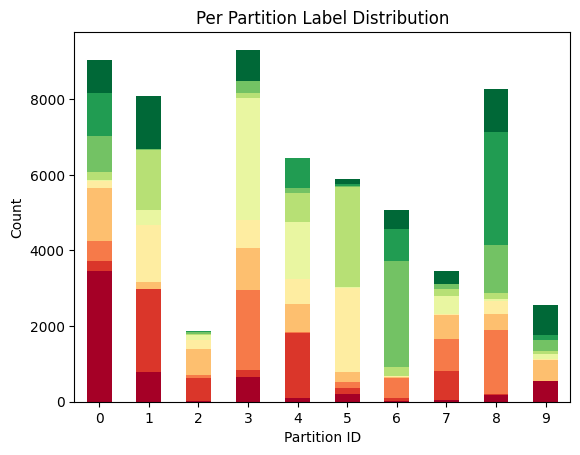

In [ ]:
from typing import Callable, Dict, List, Optional, Tuple, Union
from flwr.common import (
    EvaluateRes,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_proxy import ClientProxy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import flwr as fl
import numpy as np
import matplotlib.pyplot as plt
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.feature_selection import mutual_info_regression
from typing import List, Dict, Tuple
from flwr.common import NDArrays, EvaluateRes, Parameters, FitRes, Metrics, Context
from torchvision import transforms

# Constants
NUM_CLIENTS = 10
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.001
PRIVACY_WEIGHT = 0.001
NUM_ROUNDS = 75
NOISE_SCALE = 0.01

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Function to split MNIST using Dirichlet
def split_mnist_dirichlet_flwr(num_clients=NUM_CLIENTS, alpha=0.5, seed=42):
    partitioner = DirichletPartitioner(
        num_partitions=num_clients, partition_by="label", alpha=alpha, seed=seed
    )
    fds = FederatedDataset(dataset="fashion_mnist", partitioners={"train": partitioner})
    federated_data = {f"client_{i}": fds.load_partition(i) for i in range(num_clients)}
    return fds, federated_data  # Return both fds and federated_data

# Load and visualize data
fds, federated_data = split_mnist_dirichlet_flwr()  # Get both fds and federated_data
plot_label_distributions(fds.partitioners["train"], label_name="label")

# Function to create DataLoader for each client
def get_dataloader(client_data, batch_size=BATCH_SIZE):
    transform = transforms.Compose([
        transforms.ToTensor()  # Chuyển ảnh PIL thành tensor có giá trị trong khoảng [0,1]
    ])

    # Chuyển đổi danh sách ảnh từ PIL.Image thành tensor
    x_tensor = torch.stack([transform(img) for img in client_data["image"]])
    y_tensor = torch.tensor(client_data["label"], dtype=torch.long)

    dataset = TensorDataset(x_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define Neural Network Model
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))

        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define PPAN Encoder and Adversary
class PPAN_Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x))).detach()

class PPAN_Adversary(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(PPAN_Adversary, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define PrivacyMechanism with encrypt and decrypt functions
class PrivacyMechanism(nn.Module):
    def __init__(self, input_dim, noise_scale=NOISE_SCALE):
        super().__init__()
        self.encoder = PPAN_Encoder(input_dim, 64)
        self.adversary = PPAN_Adversary(input_dim, 64)
        self.noise_scale = noise_scale

    def encrypt(self, x):
        generated = self.encoder(x)
        if self.training:
            noise = torch.randn_like(generated) * self.noise_scale
            generated = generated + noise
        return generated

    def decrypt(self, encrypted):
        decoded = self.adversary(encrypted)
        return decoded

    def forward(self, x):
        encrypted = self.encrypt(x)
        decoded = self.decrypt(encrypted)
        return encrypted, decoded

# Compute Privacy Leakage using mutual_info_regression
def compute_privacy_leakage(encrypted_weights, original_weights):
    encrypted_weights = np.array(encrypted_weights)  # Chuyển đổi sang numpy array
    original_weights = np.array(original_weights)  # Chuyển đổi sang numpy array

    encrypted_2d = encrypted_weights.reshape(-1, 1)
    original_2d = original_weights.reshape(-1, 1)

    min_length = min(len(encrypted_2d), len(original_2d))
    encrypted_2d = encrypted_2d[:min_length]
    original_2d = original_2d[:min_length]

    try:
        mi_score = mutual_info_regression(encrypted_2d, original_2d.ravel())[0]
    except ValueError:
        mi_score = 0.0

    return mi_score

# Compute Distortion
def compute_distortion(original_weights, encrypted_weights):
    original_weights = np.array(original_weights)
    encrypted_weights = np.array(encrypted_weights)
    return np.mean((original_weights - encrypted_weights) ** 2)

# Evaluate model accuracy on test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# Define PrivacyClient for Federated Learning
class PrivacyClient(fl.client.NumPyClient):
    def __init__(self, model, train_loader, test_loader):
        self.model = model.to(DEVICE)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.param_shapes = [p.shape for p in self.model.parameters()]
        self.total_params = sum(p.numel() for p in self.model.parameters())
        self.privacy_mech = PrivacyMechanism(self.total_params, noise_scale=NOISE_SCALE).to(DEVICE)
        self.optimizer = optim.Adam(
            list(self.model.parameters()) + list(self.privacy_mech.parameters()),
            lr=LEARNING_RATE
        )

    def get_parameters(self, config=None):
        """Trả về tham số của mô hình dưới dạng danh sách NumPy arrays"""
        return [p.detach().cpu().numpy() for p in self.model.parameters()]

    def set_parameters(self, parameters):
        """Cập nhật mô hình với danh sách NumPy arrays"""
        ndarray_params = [torch.tensor(p, dtype=torch.float32, device=DEVICE) for p in parameters]
        params_dict = zip(self.model.state_dict().keys(), ndarray_params)
        state_dict = {k: v for k, v in params_dict}
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters: NDArrays, config: Dict[str, Scalar]) -> Tuple[NDArrays, int, Dict[str, Scalar]]:
        self.set_parameters(parameters)
        self.model.train()
        self.privacy_mech.train()

        total_loss, correct = 0, 0
        for images, labels in self.train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()

        avg_loss = total_loss / len(self.train_loader)
        accuracy = correct / len(self.train_loader.dataset)

        # Get model parameters and apply privacy mechanism
        with torch.no_grad():
            params = [p.detach().cpu().numpy() for p in self.model.parameters()]
            flat_params = np.concatenate([p.flatten() for p in params])
            flat_params_tensor = torch.tensor(flat_params, dtype=torch.float32).unsqueeze(0).to(DEVICE)
            encrypted_params = self.privacy_mech.encrypt(flat_params_tensor)
            encrypted_np = encrypted_params.detach().cpu().numpy()

            privacy_leakage = float(compute_privacy_leakage(encrypted_np, flat_params))
            distortion = float(compute_distortion(flat_params, encrypted_np.flatten()))

        # Return tuple with correct type signature
        return params, len(self.train_loader.dataset), {
            "loss": float(avg_loss),
            "accuracy": float(accuracy),
            "privacy_leakage": privacy_leakage,
            "distortion": distortion
        }

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]) -> Tuple[float, int, Dict[str, Scalar]]:
        self.set_parameters(parameters)
        self.model.eval()

        total_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = self.model(images)
                loss = F.cross_entropy(outputs, labels)
                total_loss += loss.item()

                predicted = outputs.argmax(dim=1)
                correct += (predicted == labels).sum().item()

            flat_params = torch.cat([p.view(-1) for p in self.model.parameters()]).unsqueeze(0).to(DEVICE)
            encrypted_params = self.privacy_mech.encrypt(flat_params)
            encrypted_np = np.array(encrypted_params.cpu().numpy().flatten(), dtype=np.float32)
            original_np = flat_params.cpu().numpy().flatten()

            privacy_leakage = compute_privacy_leakage(encrypted_np, original_np)
            distortion = compute_distortion(original_np, encrypted_np)

        avg_loss = total_loss / len(self.test_loader)
        accuracy = correct / len(self.test_loader.dataset)

        return avg_loss, len(self.test_loader.dataset), {
            "accuracy": float(accuracy),
            "privacy_leakage": float(privacy_leakage),
            "distortion": float(distortion)
        }
def aggregate_weighted_parameters(results: List[Tuple[NDArrays, int]]) -> NDArrays:
    """Aggregate model parameters using weighted average."""
    # Calculate total number of examples used during training
    total_examples = sum(num_examples for _, num_examples in results)

    if total_examples == 0:
        return None

    # Get parameter shape from first result
    params_shape = [param.shape for param in results[0][0]]
    weighted_params = [np.zeros_like(param) for param in results[0][0]]

    # Calculate weighted parameters
    for parameters, num_examples in results:
        weight = num_examples / total_examples
        for i, param in enumerate(parameters):
            weighted_params[i] += param * weight

    return weighted_params

class FedAvg_Privacy(fl.server.strategy.FedAvg):
    """Federated Averaging with Privacy strategy."""

    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[[int, NDArrays, Dict[str, Scalar]],
                    Optional[Tuple[float, Dict[str, Scalar]]]]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        noise_scale: float = NOISE_SCALE,
    ) -> None:
        """Initialize FedAvg with Privacy strategy."""
        super().__init__(
            fraction_fit=fraction_fit,
            fraction_evaluate=fraction_evaluate,
            min_fit_clients=min_fit_clients,
            min_evaluate_clients=min_evaluate_clients,
            min_available_clients=min_available_clients,
            evaluate_fn=evaluate_fn,
            on_fit_config_fn=on_fit_config_fn,
            on_evaluate_config_fn=on_evaluate_config_fn,
            accept_failures=accept_failures,
            initial_parameters=initial_parameters,
            fit_metrics_aggregation_fn=fit_metrics_aggregation_fn,
            evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
        )
        self.noise_scale = noise_scale

    def aggregate_fit(
        self,
        server_round: int,
        results: list[tuple[ClientProxy, FitRes]],
        failures: list[BaseException],
    ) -> tuple[Optional[Parameters], dict[str, Scalar]]:
        """Aggregate fit results using weighted average with privacy."""
        if not results:
            return None, {}

        # Do not aggregate if there are failures and failures are not accepted
        if not self.accept_failures and failures:
            return None, {}

        # Call parent's aggregate_fit to get aggregated parameters
        aggregated_result = super().aggregate_fit(server_round, results, failures)
        if aggregated_result is None:
            return None, {}

        parameters_aggregated, metrics = aggregated_result

        # Convert parameters to ndarrays
        ndarrays = parameters_to_ndarrays(parameters_aggregated)

        # Add noise to parameters for privacy
        parameters_noised = [
            p + np.random.normal(0, self.noise_scale, p.shape)
            for p in ndarrays
        ]

        # Aggregate metrics
        metrics_aggregated = {}
        if self.fit_metrics_aggregation_fn:
            fit_metrics = [(res.num_examples, res.metrics) for _, res in results]
            metrics_aggregated = self.fit_metrics_aggregation_fn(fit_metrics)

        # Convert back to Parameters and return
        return ndarrays_to_parameters(parameters_noised), metrics_aggregated


# Config functions for fit and evaluate
def fit_config(server_round: int) -> Dict[str, str]:
    config = {
        "learning_rate": LEARNING_RATE,
        "batch_size": BATCH_SIZE,
        "round": server_round,
    }
    return config

def evaluate_config(server_round: int) -> Dict[str, str]:
    config = {
        "batch_size": BATCH_SIZE,
        "round": server_round,
    }
    return config

def aggregate_fit_metrics(metrics: List[Tuple[int, Dict[str, Scalar]]]) -> Dict[str, Scalar]:
    aggregated_metrics = {}
    for _, client_metrics in metrics:
        for k, v in client_metrics.items():
            aggregated_metrics[k] = aggregated_metrics.get(k, 0) + v
    for k in aggregated_metrics:
        aggregated_metrics[k] /= len(metrics)
    return aggregated_metrics

# Federated Learning Simulation
def client_fn(context: Context) -> fl.client.Client:
    """Tạo một Flower client đại diện cho một tổ chức."""
    partition_id = context.node_config["partition-id"]

    # Kiểm tra nếu partition_id hợp lệ
    if f"client_{partition_id}" not in federated_data:
        raise ValueError(f"Client ID {partition_id} không tồn tại trong dữ liệu!")
    client_data = federated_data[f"client_{partition_id}"]
    train_loader = get_dataloader(client_data)
    test_loader = get_dataloader(client_data)
    model = MNISTModel()

    # Trả về client
    return PrivacyClient(model, train_loader, test_loader).to_client()

def main():
    strategy = FedAvg_Privacy(
        fraction_fit=0.1,
        fraction_evaluate=0.05,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=int(NUM_CLIENTS * 0.75),
        on_fit_config_fn=fit_config,
        on_evaluate_config_fn=evaluate_config,
        fit_metrics_aggregation_fn=aggregate_fit_metrics,
        noise_scale=NOISE_SCALE,
    )
    fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
        strategy=strategy,
    )

if __name__ == "__main__":
    main()

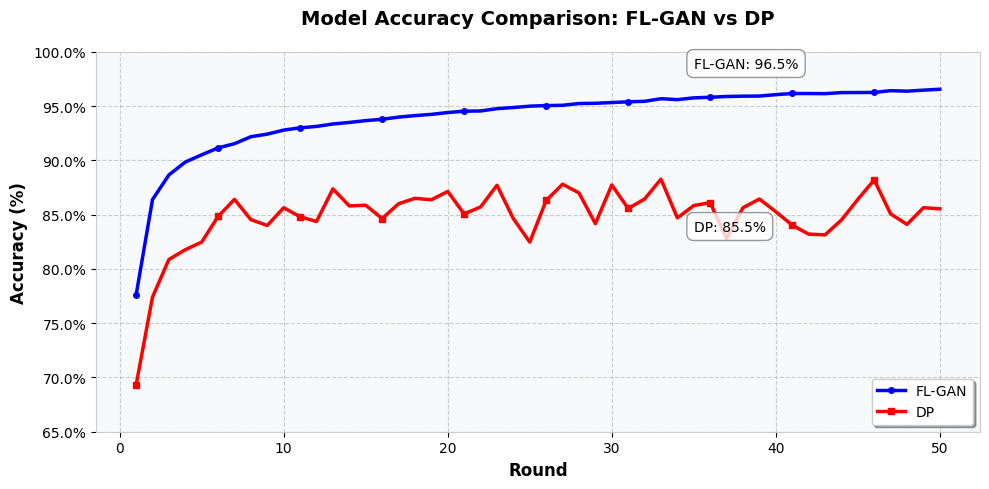

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# FL-GAN accuracy data
fl_gan_data = [(1, 0.7757430913794437), (2, 0.8638360991308579), (3, 0.886533701708448),
               (4, 0.8984014131246789), (5, 0.905095419538896), (6, 0.9114364306214535),
               (7, 0.9153417345015452), (8, 0.9217577156322989), (9, 0.9241458609284129),
               (10, 0.927864923442276), (11, 0.9299394251396749), (12, 0.9312413744575716),
               (13, 0.9334865465651099), (14, 0.9348996555758115), (15, 0.9365929792653198),
               (16, 0.9377976750400638), (17, 0.9398158591642656), (18, 0.941183926341402),
               (19, 0.9423563139042173), (20, 0.9440262131650898), (21, 0.9452868267934168),
               (22, 0.9454563237155854), (23, 0.94759770064286), (24, 0.9486474531770737),
               (25, 0.949910352190571), (26, 0.9504253094131132), (27, 0.9506963531262758),
               (28, 0.9523295654407911), (29, 0.9525522912928972), (30, 0.9532259976621272),
               (31, 0.9539158999153896), (32, 0.9543686202102002), (33, 0.9567630041785732),
               (34, 0.9559253546756118), (35, 0.9575342131893262), (36, 0.9580938375706041),
               (37, 0.9588179297882308), (38, 0.9591058305181424), (39, 0.9592209452481603),
               (40, 0.9605115600020433), (41, 0.9615678347120087), (42, 0.961530654117006),
               (43, 0.9614177074043934), (44, 0.9623914005142258), (45, 0.9624512061741111),
               (46, 0.962548393478969), (47, 0.9641733088600107), (48, 0.9637093178373044),
               (49, 0.9646471372230065), (50, 0.9654789756495343)]

# DP accuracy data
dp_data = [(1, 0.6929999947547912), (2, 0.7740000009536743), (3, 0.8086666703224182),
          (4, 0.8176666617393493), (5, 0.8246666550636291), (6, 0.8483333230018616),
          (7, 0.8640000104904175), (8, 0.8453333377838135), (9, 0.8400000095367431),
          (10, 0.8563333511352539), (11, 0.8479999899864197), (12, 0.8436666607856751),
          (13, 0.8736666798591614), (14, 0.8580000042915344), (15, 0.8586666703224182),
          (16, 0.8463333368301391), (17, 0.8600000143051147), (18, 0.8650000095367432),
          (19, 0.8636666774749756), (20, 0.8713333368301391), (21, 0.8506666779518127),
          (22, 0.8570000171661377), (23, 0.8769999980926514), (24, 0.8463333368301391),
          (25, 0.8246666550636291), (26, 0.8630000114440918), (27, 0.877999997138977),
          (28, 0.8700000047683716), (29, 0.8416666626930237), (30, 0.8773333311080933),
          (31, 0.8556666731834411), (32, 0.8643333435058593), (33, 0.8826666593551635),
          (34, 0.847000002861023), (35, 0.8583333492279053), (36, 0.8610000133514404),
          (37, 0.8279999971389771), (38, 0.856333327293396), (39, 0.8643333315849304),
          (40, 0.8526666760444641), (41, 0.8403333306312561), (42, 0.8319999814033509),
          (43, 0.831333327293396), (44, 0.8449999928474426), (45, 0.8639999985694885),
          (46, 0.8819999933242798), (47, 0.8506666898727417), (48, 0.840999984741211),
          (49, 0.856333339214325), (50, 0.8553333282470703)]


plt.figure(figsize=(10, 5))

# Plot data with enhanced styling
plt.plot([x[0] for x in fl_gan_data],
         [y[1] * 100 for y in fl_gan_data],
         'b-', label='FL-GAN', linewidth=2.5,
         marker='o', markersize=4, markevery=5)

plt.plot([x[0] for x in dp_data],
         [y[1] * 100 for y in dp_data],
         'r-', label='DP', linewidth=2.5,
         marker='s', markersize=4, markevery=5)

# Enhance visual style
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Round', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Model Accuracy Comparison: FL-GAN vs DP',
         fontsize=14, fontweight='bold', pad=20)

# Customize legend
plt.legend(fontsize=10, frameon=True, fancybox=True,
          shadow=True, loc='lower right')

# Set axis limits and format
plt.ylim(65, 100)
plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f%%'))

# Add final accuracy annotations with styled boxes
final_fl_gan = fl_gan_data[-1][1] * 100
final_dp = dp_data[-1][1] * 100

bbox_props = dict(boxstyle="round,pad=0.5", fc="white",
                 ec="gray", alpha=0.8)

plt.annotate(f'FL-GAN: {final_fl_gan:.1f}%',
            xy=(50, final_fl_gan),
            xytext=(35, final_fl_gan + 2),
            fontsize=10,
            bbox=bbox_props)

plt.annotate(f'DP: {final_dp:.1f}%',
            xy=(50, final_dp),
            xytext=(35, final_dp - 2),
            fontsize=10,
            bbox=bbox_props)

# Add subtle background gradient
ax = plt.gca()
ax.set_facecolor('#f8f9fa')
plt.grid(True, linestyle='--', alpha=0.6)

# Add a light box around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('#CCCCCC')

# Adjust layout and display
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


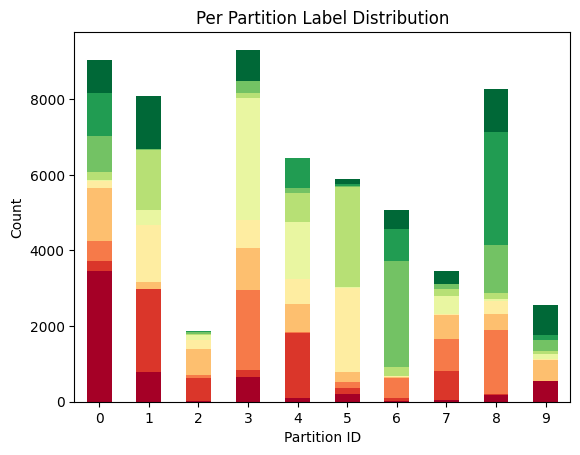

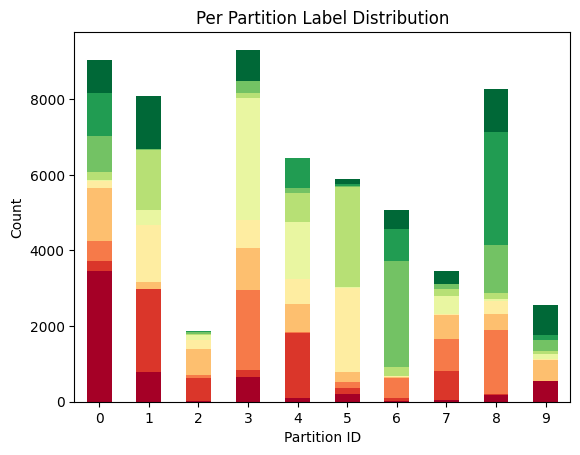

In [ ]:
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import flwr as fl
import numpy as np
import matplotlib.pyplot as plt
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import mutual_info_regression
from typing import List, Dict, Tuple, Optional, Callable, Union
from flwr.common import (
    EvaluateRes,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
    Context
)
from flwr.server.client_proxy import ClientProxy
from torchvision import transforms

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Constants
NUM_CLIENTS = 10
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.001
PRIVACY_WEIGHT = 0.001
NUM_ROUNDS = 75
NOISE_SCALE = 0.01
DIRICHLET_ALPHA = 0.5

# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

def split_mnist_dirichlet_flwr(num_clients=NUM_CLIENTS, alpha=DIRICHLET_ALPHA, seed=42):
    """Split MNIST using Dirichlet partitioning"""
    partitioner = DirichletPartitioner(
        num_partitions=num_clients,
        partition_by="label",
        alpha=alpha,
        seed=seed
    )
    fds = FederatedDataset(dataset="mnist", partitioners={"train": partitioner})
    federated_data = {
        f"client_{i}": fds.load_partition(i)
        for i in range(num_clients)
    }
    return fds, federated_data

def get_dataloader(client_data, batch_size=BATCH_SIZE):
    """Create DataLoader from client data"""
    transform = transforms.Compose([transforms.ToTensor()])
    x_tensor = torch.stack([transform(img) for img in client_data["image"]])
    y_tensor = torch.tensor(client_data["label"], dtype=torch.long)
    dataset = TensorDataset(x_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

class Generator(nn.Module):
    """Generator network for privacy preservation"""
    def __init__(self, latent_dim=100, output_dim=784):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    """Discriminator network for adversarial training"""
    def __init__(self, input_dim=784):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

class PrivacyGAN:
    """GAN-based privacy mechanism"""
    def __init__(self, input_dim=784, latent_dim=100):
        self.generator = Generator(latent_dim, input_dim).to(DEVICE)
        self.discriminator = Discriminator(input_dim).to(DEVICE)
        self.latent_dim = latent_dim

        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=0.0002)
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.0002)

    def train_step(self, real_data):
        batch_size = real_data.size(0)

        # Train Discriminator
        self.d_optimizer.zero_grad()
        label_real = torch.ones(batch_size, 1).to(DEVICE)
        label_fake = torch.zeros(batch_size, 1).to(DEVICE)

        output_real = self.discriminator(real_data.view(batch_size, -1))
        d_loss_real = F.binary_cross_entropy(output_real, label_real)

        noise = torch.randn(batch_size, self.latent_dim).to(DEVICE)
        fake_data = self.generator(noise)
        output_fake = self.discriminator(fake_data.detach())
        d_loss_fake = F.binary_cross_entropy(output_fake, label_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        self.d_optimizer.step()

        # Train Generator
        self.g_optimizer.zero_grad()
        output_fake = self.discriminator(fake_data)
        g_loss = F.binary_cross_entropy(output_fake, label_real)
        g_loss.backward()
        self.g_optimizer.step()

        return d_loss.item(), g_loss.item()

    def privatize(self, data):
        """Apply privacy transformation to data"""
        self.generator.eval()
        with torch.no_grad():
            noise = torch.randn(data.size(0), self.latent_dim).to(DEVICE)
            private_data = self.generator(noise)
            return private_data.view_as(data)

class PrivacyClient(fl.client.NumPyClient):
    """Client with GAN-based privacy"""
    def __init__(self, model, train_loader, test_loader):
        self.model = model.to(DEVICE)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.privacy_gan = PrivacyGAN()
        self.criterion = nn.CrossEntropyLoss()

    def get_parameters(self, config=None):
        return [val.cpu().numpy() for val in self.model.state_dict().values()]

    def set_parameters(self, parameters):
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = {k: torch.tensor(v) for k, v in params_dict}
        self.model.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.train()

        metrics = {"loss": 0, "accuracy": 0}

        for data, target in self.train_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            # Apply privacy mechanism
            private_data = self.privacy_gan.privatize(data)

            # Train model
            self.optimizer.zero_grad()
            output = self.model(private_data)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()

            # Update metrics
            metrics["loss"] += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            metrics["accuracy"] += pred.eq(target.view_as(pred)).sum().item()

            # Train privacy GAN
            d_loss, g_loss = self.privacy_gan.train_step(data)
            metrics["d_loss"] = d_loss
            metrics["g_loss"] = g_loss

        num_samples = len(self.train_loader.dataset)
        metrics = {k: v / num_samples for k, v in metrics.items()}

        return self.get_parameters({}), num_samples, metrics

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        self.model.eval()

        loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(DEVICE), target.to(DEVICE)
                private_data = self.privacy_gan.privatize(data)
                output = self.model(private_data)
                loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        num_samples = len(self.test_loader.dataset)
        loss = loss / num_samples
        accuracy = correct / num_samples

        return loss, num_samples, {"accuracy": accuracy}

def main():
    """Main training function"""
    try:
        logger.info("Starting Federated Learning with GAN Privacy...")

        # Load and partition data
        fds, federated_data = split_mnist_dirichlet_flwr()
        logger.info("Data partitioned successfully")

        # Create strategy
        strategy = fl.server.strategy.FedAvg(
            fraction_fit=0.3,
            fraction_evaluate=1.0,
            min_fit_clients=3,
            min_evaluate_clients=NUM_CLIENTS,
            min_available_clients=NUM_CLIENTS
        )

        # Start simulation
        history = fl.simulation.start_simulation(
            client_fn=lambda cid: PrivacyClient(
                MNISTModel(),
                get_dataloader(federated_data[f"client_{cid}"]),
                get_dataloader(federated_data[f"client_{cid}"])
            ),
            num_clients=NUM_CLIENTS,
            config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
            strategy=strategy
        )

        # Print results
        print("\nTraining Results:")
        print("-" * 50)
        for round_num, metrics in enumerate(history.metrics_distributed, 1):
            print(f"Round {round_num}:")
            if isinstance(metrics, dict):
                print(f"  Loss: {metrics['loss']:.4f}")
                print(f"  Accuracy: {metrics['accuracy']:.4f}")
                if 'd_loss' in metrics:
                    print(f"  Discriminator Loss: {metrics['d_loss']:.4f}")
                if 'g_loss' in metrics:
                    print(f"  Generator Loss: {metrics['g_loss']:.4f}")
            else:
                print(f"  Loss: {metrics:.4f}")
        print("-" * 50)

    except Exception as e:
        logger.error(f"Training failed: {str(e)}")
        logger.error(traceback.format_exc())

if __name__ == "__main__":
    main()

In [ ]:
# Add new imports
import numpy as np
from skimage.metrics import structural_similarity as ssim
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Config functions for fit and evaluate
def fit_config(server_round: int) -> Dict[str, str]:
    config = {
        "learning_rate": LEARNING_RATE,
        "batch_size": BATCH_SIZE,
        "round": server_round,
    }
    return config

def evaluate_config(server_round: int) -> Dict[str, str]:
    config = {
        "batch_size": BATCH_SIZE,
        "round": server_round,
    }
    return config

def aggregate_fit_metrics(metrics: List[Tuple[int, Dict[str, Scalar]]]) -> Dict[str, Scalar]:
    aggregated_metrics = {}
    for _, client_metrics in metrics:
        for k, v in client_metrics.items():
            aggregated_metrics[k] = aggregated_metrics.get(k, 0) + v
    for k in aggregated_metrics:
        aggregated_metrics[k] /= len(metrics)
    return aggregated_metrics

def compute_ssim(original_weights, encrypted_weights):
    """Compute SSIM between original and encrypted weights with proper reshaping"""
    orig = np.array(original_weights).flatten()
    encr = np.array(encrypted_weights).flatten()

    # Calculate the minimum size needed for SSIM (at least 7x7)
    min_size = int(np.ceil(np.sqrt(len(orig))))
    if min_size < 7:
        min_size = 7

    # Pad arrays if needed
    pad_size = min_size * min_size - len(orig)
    if pad_size > 0:
        orig = np.pad(orig, (0, pad_size), mode='constant')
        encr = np.pad(encr, (0, pad_size), mode='constant')

    # Reshape to 2D arrays
    orig_2d = orig.reshape(min_size, min_size)
    encr_2d = encr.reshape(min_size, min_size)

    # Calculate SSIM with explicit window size
    win_size = min(7, min_size)
    if win_size % 2 == 0:
        win_size -= 1  # Ensure window size is odd

    return ssim(orig_2d, encr_2d,
                win_size=win_size,
                data_range=orig_2d.max() - orig_2d.min())

def compute_kl_divergence(original_weights, poisoned_weights):
    """Compute KL divergence between original and poisoned weights"""
    orig = np.array(original_weights).flatten()
    pois = np.array(poisoned_weights).flatten()
    # Normalize to create proper probability distributions
    orig = np.abs(orig) / (np.sum(np.abs(orig)) + 1e-10)
    pois = np.abs(pois) / (np.sum(np.abs(pois)) + 1e-10)
    return entropy(orig + 1e-10, pois + 1e-10)

class MaliciousClient(PrivacyClient):
    def __init__(self, model, train_loader, test_loader, poison_intensity=0.1):
        super().__init__(model, train_loader, test_loader)
        self.poison_intensity = poison_intensity
        self.metrics_history = {
            'train_accuracy': [],
            'test_accuracy': [],
            'information_leakage': [],
            'poison_effect': [],
            'kl_divergence': [],
            'ssim_score': []
        }

    def fit(self, parameters: NDArrays, config: Dict[str, Scalar]) -> Tuple[NDArrays, int, Dict[str, Scalar]]:
        # Normal training first
        self.set_parameters(parameters)
        self.model.train()
        self.privacy_mech.train()

        train_predictions = []
        train_labels = []
        total_loss = 0

        for images, labels in self.train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            pred = outputs.argmax(dim=1)
            train_predictions.extend(pred.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Get original parameters
        orig_params = [p.detach().cpu().numpy() for p in self.model.parameters()]
        flat_orig = np.concatenate([p.flatten() for p in orig_params])

        # Apply poisoning attack
        poisoned_params = []
        for param in orig_params:
            noise = np.random.normal(0, self.poison_intensity, param.shape)
            poisoned_param = param + noise
            poisoned_params.append(poisoned_param)

        # Compute metrics
        flat_poisoned = np.concatenate([p.flatten() for p in poisoned_params])
        train_metrics = {
            'accuracy': accuracy_score(train_labels, train_predictions),
            'precision': precision_score(train_labels, train_predictions, average='weighted'),
            'recall': recall_score(train_labels, train_predictions, average='weighted'),
            'f1': f1_score(train_labels, train_predictions, average='weighted')
        }

        # Compute privacy and poisoning metrics
        kl_div = compute_kl_divergence(flat_orig, flat_poisoned)
        ssim_score = compute_ssim(flat_orig, flat_poisoned)
        info_leakage = compute_privacy_leakage(flat_poisoned, flat_orig)

        # Update metrics history
        self.metrics_history['train_accuracy'].append(train_metrics['accuracy'])
        self.metrics_history['information_leakage'].append(info_leakage)
        self.metrics_history['poison_effect'].append(self.poison_intensity)
        self.metrics_history['kl_divergence'].append(kl_div)
        self.metrics_history['ssim_score'].append(ssim_score)

        metrics = {
            'train_loss': total_loss / len(self.train_loader),
            'train_accuracy': train_metrics['accuracy'],
            'train_precision': train_metrics['precision'],
            'train_recall': train_metrics['recall'],
            'train_f1': train_metrics['f1'],
            'information_leakage': info_leakage,
            'poison_intensity': self.poison_intensity,
            'kl_divergence': kl_div,
            'ssim_score': ssim_score,
            'is_poisoned': 1.0
        }

        return poisoned_params, len(self.train_loader.dataset), metrics

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]) -> Tuple[float, int, Dict[str, Scalar]]:
        self.set_parameters(parameters)
        self.model.eval()

        test_predictions = []
        test_labels = []
        total_loss = 0

        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = self.model(images)
                loss = F.cross_entropy(outputs, labels)
                total_loss += loss.item()

                pred = outputs.argmax(dim=1)
                test_predictions.extend(pred.cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

            # Get model parameters
            params = [p.detach().cpu().numpy() for p in self.model.parameters()]
            flat_params = np.concatenate([p.flatten() for p in params])

            # Apply poisoning for evaluation
            poisoned_params = flat_params + np.random.normal(0, self.poison_intensity, flat_params.shape)

            # Compute metrics
            test_metrics = {
                'accuracy': accuracy_score(test_labels, test_predictions),
                'precision': precision_score(test_labels, test_predictions, average='weighted'),
                'recall': recall_score(test_labels, test_predictions, average='weighted'),
                'f1': f1_score(test_labels, test_predictions, average='weighted')
            }

            kl_div = compute_kl_divergence(flat_params, poisoned_params)
            ssim_score = compute_ssim(flat_params, poisoned_params)
            info_leakage = compute_privacy_leakage(poisoned_params, flat_params)

        self.metrics_history['test_accuracy'].append(test_metrics['accuracy'])

        metrics = {
            'test_loss': total_loss / len(self.test_loader),
            'test_accuracy': test_metrics['accuracy'],
            'test_precision': test_metrics['precision'],
            'test_recall': test_metrics['recall'],
            'test_f1': test_metrics['f1'],
            'information_leakage': info_leakage,
            'kl_divergence': kl_div,
            'ssim_score': ssim_score
        }

        return total_loss, len(self.test_loader.dataset), metrics

# Update client_fn to include malicious clients
def client_fn(context: Context) -> fl.client.Client:
    partition_id = context.node_config["partition-id"]

    if f"client_{partition_id}" not in federated_data:
        raise ValueError(f"Client ID {partition_id} không tồn tại trong dữ liệu!")

    client_data = federated_data[f"client_{partition_id}"]
    train_loader = get_dataloader(client_data)
    test_loader = get_dataloader(client_data)
    model = MNISTModel()

    # 10% chance of creating a malicious client
    if np.random.random() < 0.1:
        print(f"Client {partition_id} is malicious!")
        return MaliciousClient(
            model,
            train_loader,
            test_loader,
            poison_intensity=0.1
        ).to_client()
    else:
        return PrivacyClient(model, train_loader, test_loader).to_client()

# Update FedAvg_Privacy to handle poisoning metrics
class FedAvg_Privacy(fl.server.strategy.FedAvg):
    """Federated Averaging with Privacy strategy."""

    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
        evaluate_fn: Optional[
            Callable[[int, NDArrays, Dict[str, Scalar]],
                    Optional[Tuple[float, Dict[str, Scalar]]]]
        ] = None,
        on_fit_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        on_evaluate_config_fn: Optional[Callable[[int], Dict[str, Scalar]]] = None,
        accept_failures: bool = True,
        initial_parameters: Optional[Parameters] = None,
        fit_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        evaluate_metrics_aggregation_fn: Optional[MetricsAggregationFn] = None,
        noise_scale: float = NOISE_SCALE,
    ) -> None:
        # Remove noise_scale from kwargs before passing to parent
        kwargs = {
            'fraction_fit': fraction_fit,
            'fraction_evaluate': fraction_evaluate,
            'min_fit_clients': min_fit_clients,
            'min_evaluate_clients': min_evaluate_clients,
            'min_available_clients': min_available_clients,
            'evaluate_fn': evaluate_fn,
            'on_fit_config_fn': on_fit_config_fn,
            'on_evaluate_config_fn': on_evaluate_config_fn,
            'accept_failures': accept_failures,
            'initial_parameters': initial_parameters,
            'fit_metrics_aggregation_fn': fit_metrics_aggregation_fn,
            'evaluate_metrics_aggregation_fn': evaluate_metrics_aggregation_fn,
        }

        super().__init__(**kwargs)
        self.noise_scale = noise_scale
        self.metrics_history = {
            'round': [],
            'avg_train_accuracy': [],
            'avg_test_accuracy': [],
            'avg_information_leakage': [],
            'num_poisoned_clients': [],
            'avg_kl_divergence': [],
            'avg_ssim_score': []
        }

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[BaseException],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results with privacy metrics."""
        if not results:
            return None, {}

        # Extract metrics and parameters from results
        aggregated_metrics = {}
        try:
            # Get parameters and metrics from all clients
            parameters_list = []
            metrics_list = []
            for _, fit_res in results:
                parameters_list.append(
                    (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
                )
                metrics_list.append((fit_res.num_examples, fit_res.metrics))

            # Aggregate parameters
            aggregated_ndarrays = aggregate_weighted_parameters(parameters_list)
            if aggregated_ndarrays is None:
                return None, {}

            # Add privacy noise
            parameters_noised = [
                p + np.random.normal(0, self.noise_scale, p.shape)
                for p in aggregated_ndarrays
            ]

            # Aggregate metrics
            if metrics_list:
                total_examples = sum(num_examples for num_examples, _ in metrics_list)
                aggregated_metrics = {
                    "accuracy": np.mean([
                        m["accuracy"] * num_examples / total_examples
                        for num_examples, m in metrics_list
                    ]),
                    "loss": np.mean([
                        m["loss"] * num_examples / total_examples
                        for num_examples, m in metrics_list
                    ]),
                    "privacy_leakage": np.mean([
                        m.get("privacy_leakage", 0) * num_examples / total_examples
                        for num_examples, m in metrics_list
                    ]),
                    "distortion": np.mean([
                        m.get("distortion", 0) * num_examples / total_examples
                        for num_examples, m in metrics_list
                    ])
                }

            # Add round number to metrics
            aggregated_metrics["round"] = server_round

            return ndarrays_to_parameters(parameters_noised), aggregated_metrics

        except Exception as e:
            print(f"Error in aggregate_fit: {str(e)}")
            return None, {}

    def plot_metrics(self):
        """Plot training metrics"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        rounds = self.metrics_history['round']

        # Plot accuracies
        ax1.plot(rounds, self.metrics_history['avg_train_accuracy'], label='Clean Train')
        ax1.plot(rounds, self.metrics_history['avg_test_accuracy'], label='Clean Test')
        if 'avg_poisoned_train_accuracy' in self.metrics_history:
            ax1.plot(rounds, self.metrics_history['avg_poisoned_train_accuracy'],
                    label='Poisoned Train', linestyle='--')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Round')
        ax1.set_ylabel('Accuracy')
        ax1.legend()

        # Plot information leakage
        ax2.plot(rounds, self.metrics_history['avg_information_leakage'],
                label='Info Leakage', color='red')
        ax2.set_title('Information Leakage')
        ax2.set_xlabel('Round')
        ax2.set_ylabel('Leakage')
        ax2.legend()

        # Plot KL divergence
        ax3.plot(rounds, self.metrics_history['avg_kl_divergence'],
                label='KL Divergence', color='green')
        ax3.set_title('KL Divergence')
        ax3.set_xlabel('Round')
        ax3.set_ylabel('KL Divergence')
        ax3.legend()

        # Plot SSIM
        ax4.plot(rounds, self.metrics_history['avg_ssim_score'],
                label='SSIM Score', color='purple')
        ax4.set_title('Structural Similarity')
        ax4.set_xlabel('Round')
        ax4.set_ylabel('SSIM Score')
        ax4.legend()

        plt.tight_layout()
        plt.show()

def main():
    strategy = FedAvg_Privacy(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=NUM_CLIENTS,
        min_available_clients=NUM_CLIENTS,
        on_fit_config_fn=fit_config,
        on_evaluate_config_fn=evaluate_config,
        fit_metrics_aggregation_fn=aggregate_fit_metrics,
        noise_scale=NOISE_SCALE  # This will now be properly handled
    )

    fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
        strategy=strategy,
    )

if __name__ == "__main__":
    main()

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2025-02-26 17:18:58,449	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resource

(ClientAppActor pid=8775) Client 9 is malicious!


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8775) Client 3 is malicious!
(ClientAppActor pid=8775) Client 1 is malicious!


(ClientAppActor pid=8775) /usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=8775)   _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
(pid=8774) 2025-02-26 17:19:04.672863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=8774) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=8774) E0000 00:00:1740590344.779100    8774 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=8774) E0000 00:00:1740590344.805667    8774 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register 

Error in aggregate_fit: 'accuracy'


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8774) Client 6 is malicious!


(ClientAppActor pid=8774) /usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
(ClientAppActor pid=8774)   _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Error in aggregate_fit: 'accuracy'


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8775) Client 0 is malicious!


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Error in aggregate_fit: 'accuracy'
(ClientAppActor pid=8774) Client 8 is malicious!


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8774) Client 5 is malicious!


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Error in aggregate_fit: 'accuracy'
(ClientAppActor pid=8775) Client 5 is malicious!
(ClientAppActor pid=8774) Client 4 is malicious!
(ClientAppActor pid=8774) Client 1 is malicious!


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8775) Client 8 is malicious!


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Error in aggregate_fit: 'accuracy'
(ClientAppActor pid=8774) Client 7 is malicious!
(ClientAppActor pid=8774) Client 8 is malicious!


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8775) Client 9 is malicious!
(ClientAppActor pid=8775) Client 7 is malicious!


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8774) Client 8 is malicious!
(ClientAppActor pid=8775) Client 5 is malicious!


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Error in aggregate_fit: 'accuracy'


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8775) Client 1 is malicious!
(ClientAppActor pid=8774) Client 7 is malicious!


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Error in aggregate_fit: 'accuracy'
(ClientAppActor pid=8774) Client 1 is malicious!


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 1214.28s
INFO :      	History (loss, distributed):
INFO :      		round 1: 6.936380189362811
INFO :      		round 2: 1.0359778823769477
INFO :      		round 3: 1.0356623800243543
INFO :      		round 4: 79.02393985409698
INFO :      		round 5: 150.53092711815725
INFO :      		round 6: 0.5609784290045986
INFO :      		round 7: 42.435564478192305
INFO :      		round 8: 8.356003866794078
INFO :      		round 9: 0.47512399852178544
INFO :      		round 10: 31.341609314665085
INFO :      	History (metrics, distributed, fit):
INFO :      	{'accuracy': [(1, 0.07789833333333332),
INFO :      	              (6, 0.08532166666666666),
INFO :      	              (8, 0.08777333333333334)],
INFO :      	 'distortion': [(1, 0.0006189937663908737),
INFO :      	                (6, 0.0006492251168082779),
INFO :      	                (8, 0.0007001657194582124)],
INFO :